# Task A.1

Objective:
- Normalizing column names and light string cleanup.
- Checking key missing-value hypotheses with simple, transparent summaries.
- Labeling implausible zeros as missing (NaN) without imputing values.
- Computing temporary unit weights for each supplier to assist analysis, then removing them from the final output.
- Concatenating the two sources (no merge key!).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Load data
Using relative paths under this repository.

In [4]:
p1 = 'task_1/supplier_data1.xlsx'
p2 = 'task_1/supplier_data2.xlsx'
df1 = pd.read_excel(p1)
df2 = pd.read_excel(p2)
df1.head(), df2.head()

(  Quality/Choice  Grade               Finish  Thickness (mm)  Width (mm)  \
 0            3rd  C200S  gebeizt und geglüht            2.77        1100   
 1            3rd  C300S            ungebeizt            2.65        1075   
 2            3rd  C100S  gebeizt und geglüht            2.20        1100   
 3            2nd  C100S              gebeizt            2.86        1100   
 4            1st  C300S            ungebeizt            2.88        1050   
 
                           Description  Gross weight (kg)   RP02      RM  \
 0                Längs- oder Querisse              13983  333.6   606.2   
 1                Längs- oder Querisse              13047  717.7     0.0   
 2       Kantenfehler - FS-Kantenrisse              14155  368.9     0.0   
 3                Längs- oder Querisse              11381  368.9   601.7   
 4  Sollmasse (Gewicht) unterschritten              10072    0.0  1213.0   
 
    Quantity     AG      AI  
 0      0.00  16.11  0.0054  
 1      0.00  16.1

## Normalize columns
- Convert to snake_case and align semantics across files.
- Light cleanup of text columns for Supplier 2.

In [5]:
normalized_cols_1 = {
    'Quality/Choice': 'quality_choice',
    'Grade': 'grade',
    'Finish': 'finish',
    'Thickness (mm)': 'thickness_mm',
    'Width (mm)': 'width_mm',
    'Description': 'defect_desc',
    'Gross weight (kg)': 'sup1_weight_kg',
    'RP02': 'rp02',
    'RM': 'rm',
    'Quantity': 'sup1_quantity',
    'AG': 'ag',
    'AI': 'ai',
}

normalized_cols_2 = {
    'Material': 'material',
    'Description': 'coating_desc',
    'Article ID': 'article_id',
    'Weight (kg)': 'sup2_weight_kg',
    'Quantity': 'sup2_quantity',
    'Reserved': 'reserved',
}

df1 = df1.rename(columns=normalized_cols_1)
df2 = df2.rename(columns=normalized_cols_2)

if 'coating_desc' in df2:
    df2['coating_desc'] = (
        df2['coating_desc']
          .astype(str).str.strip().str.split().str[-1].str.lower()
    )
if 'reserved' in df2:
    df2['reserved'] = (
        df2['reserved'].astype(str).str.lower().str.strip().str.replace(' ', '_', regex=False)
    )

df1.head(), df2.head()

(  quality_choice  grade               finish  thickness_mm  width_mm  \
 0            3rd  C200S  gebeizt und geglüht          2.77      1100   
 1            3rd  C300S            ungebeizt          2.65      1075   
 2            3rd  C100S  gebeizt und geglüht          2.20      1100   
 3            2nd  C100S              gebeizt          2.86      1100   
 4            1st  C300S            ungebeizt          2.88      1050   
 
                           defect_desc  sup1_weight_kg   rp02      rm  \
 0                Längs- oder Querisse           13983  333.6   606.2   
 1                Längs- oder Querisse           13047  717.7     0.0   
 2       Kantenfehler - FS-Kantenrisse           14155  368.9     0.0   
 3                Längs- oder Querisse           11381  368.9   601.7   
 4  Sollmasse (Gewicht) unterschritten           10072    0.0  1213.0   
 
    sup1_quantity     ag      ai  
 0           0.00  16.11  0.0054  
 1           0.00  16.11  0.0046  
 2          10.

## Key hypotheses about missingness
We evaluate practical checks before deciding on imputation:
1) Quantity–weight inconsistencies exist (`quantity == 0` while `weight > 0`).
2) Mechanical properties (`rp02`, `rm`, `ag`) have zero values that likely represent missing.
3) Zeros are not strongly tied to any category (grade/finish/defect) — weak evidence for group-wise imputation.

In [6]:
# 1) Quantity–weight inconsistencies for Supplier 1
df1['quantity_weight_conflict'] = (df1.get('sup1_quantity', 0).fillna(0) == 0) & (df1.get('sup1_weight_kg', 0).fillna(0) > 0)
conflict_count = int(df1['quantity_weight_conflict'].sum())
conflict_count

# 2) Mechanical zeros likely missing
mech_cols = [c for c in ['rp02','rm','ag'] if c in df1.columns]
zero_counts = {c: int((df1[c] == 0).sum()) for c in mech_cols}
total_rows = len(df1)
summary_zeros = pd.DataFrame({'zero_count': pd.Series(zero_counts),
                               'zero_pct': pd.Series({c: 100*(df1[c]==0).mean() for c in mech_cols})})
summary_zeros

# 3) Quick group-wise zero rates (weak/no strong structure expected)
def zero_rate_by(df, col, by):
    return (df.assign(__zero=(df[col]==0))
              .groupby(by)['__zero']
              .mean()
              .mul(100)
              .rename(f'{col}_zero_pct'))

by_grade = zero_rate_by(df1, mech_cols[0], 'grade') if 'grade' in df1 and mech_cols else pd.Series(dtype=float)
by_finish = zero_rate_by(df1, mech_cols[0], 'finish') if 'finish' in df1 and mech_cols else pd.Series(dtype=float)
by_defect = zero_rate_by(df1, mech_cols[0], 'defect_desc') if 'defect_desc' in df1 and mech_cols else pd.Series(dtype=float)
by_grade, by_finish, by_defect

(grade
 C100S    23.076923
 C200S    20.000000
 C300S    35.714286
 Name: rp02_zero_pct, dtype: float64,
 finish
 gebeizt                35.294118
 gebeizt und geglüht    15.789474
 ungebeizt              28.571429
 Name: rp02_zero_pct, dtype: float64,
 defect_desc
 Kantenfehler - FS-Kantenrisse          9.090909
 Längs- oder Querisse                  26.086957
 Sollmasse (Gewicht) unterschritten    37.500000
 Name: rp02_zero_pct, dtype: float64)

Conclusion: Inconsistencies exist and zeros in mechanicals are present, but group-wise patterns are weak.
We proceed without imputation, treating implausible zeros as missing values.

In [12]:
num_cols = ["sup1_quantity", "sup1_weight_kg", "rp02", "rm", "ag", "ai", "thickness_mm", "width_mm"]
cat_cols = ["grade", "finish", "defect_desc", "quality_choice"]

In [11]:
from utils.correlations import *

In [ ]:
cramer_matrix = cat_cat_assoc_matrix(df1, cat_cols)
cramer_matrix

,grade,finish,defect_desc,quality_choice
grade,1.000000,0.034415,0.000000,0.000000
finish,0.034415,1.000000,0.095995,0.000000
defect_desc,0.000000,0.095995,1.000000,0.196829
quality_choice,0.000000,0.000000,0.196829,1.000000


In [14]:
eta_matrix = cat_num_assoc_matrix(df1, cat_cols, num_cols)
eta_matrix

,sup1_quantity,sup1_weight_kg,rp02,rm,ag,ai,thickness_mm,width_mm
grade,0.414577,0.090737,0.235434,0.235563,0.291663,0.227467,0.063162,0.210825
finish,0.226277,0.225616,0.176027,0.193389,0.055283,0.211838,0.041130,0.174480
defect_desc,0.266664,0.142282,0.100730,0.181004,0.284408,0.384336,0.192336,0.242941
quality_choice,0.155095,0.243416,0.239995,0.057080,0.090945,0.096125,0.133678,0.153448


In [15]:
corr_num = numeric_corr(df1, num_cols) 
corr_num

,sup1_quantity,sup1_weight_kg,rp02,rm,ag,ai,thickness_mm,width_mm
sup1_quantity,1.000000,-0.119065,0.048723,0.041512,0.202365,-0.362574,-0.251271,-0.098523
sup1_weight_kg,-0.119065,1.000000,-0.258396,0.039499,0.239779,-0.078682,0.070951,-0.001473
rp02,0.048723,-0.258396,1.000000,0.121067,-0.113242,-0.228149,0.447403,-0.055019
rm,0.041512,0.039499,0.121067,1.000000,-0.015691,-0.259483,-0.119950,-0.025156
ag,0.202365,0.239779,-0.113242,-0.015691,1.000000,0.066501,-0.059038,-0.279106
ai,-0.362574,-0.078682,-0.228149,-0.259483,0.066501,1.000000,-0.234271,0.132822
thickness_mm,-0.251271,0.070951,0.447403,-0.119950,-0.059038,-0.234271,1.000000,-0.061038
width_mm,-0.098523,-0.001473,-0.055019,-0.025156,-0.279106,0.132822,-0.061038,1.000000


Overall again week correlations (for small sample size)

## Label implausible zeros as NaN (no imputation)
Rules:
- For Supplier 1: `rp02`, `rm`, `ag` zeros → NaN.
- For Supplier 1: if `sup1_quantity == 0` and `sup1_weight_kg > 0`, set `sup1_quantity = NaN`.
- For Supplier 2: if present, set `sup2_quantity == 0` → NaN (symmetric policy).
- Compute temporary `sup1_unit_weight` and `sup2_unit_weight` only for rows with strictly positive quantities; these columns are later dropped.

In [7]:
# Supplier 1: convert zeros in mechanicals to NaN
for col in mech_cols:
    if col in df1:
        df1[col] = df1[col].replace(0, np.nan)

# Supplier 1: quantity zero but weight positive → mark as missing
mask_conflict = df1['quantity_weight_conflict']
if 'sup1_quantity' in df1:
    df1.loc[mask_conflict, 'sup1_quantity'] = np.nan

# Supplier 2: treat zero quantity as missing if column exists
if 'sup2_quantity' in df2:
    df2['sup2_quantity'] = df2['sup2_quantity'].replace(0, np.nan)

# temporary unit weights(strictly positive quantities only)
if {'sup1_weight_kg','sup1_quantity'}.issubset(df1.columns):
    df1['sup1_unit_weight'] = np.where(df1['sup1_quantity']>0,
                                       df1['sup1_weight_kg']/df1['sup1_quantity'],
                                       np.nan)
if {'sup2_weight_kg','sup2_quantity'}.issubset(df2.columns):
    df2['sup2_unit_weight'] = np.where(df2['sup2_quantity']>0,
                                       df2['sup2_weight_kg']/df2['sup2_quantity'],
                                       np.nan)

df1.head(), df2.head()

(  quality_choice  grade               finish  thickness_mm  width_mm  \
 0            3rd  C200S  gebeizt und geglüht          2.77      1100   
 1            3rd  C300S            ungebeizt          2.65      1075   
 2            3rd  C100S  gebeizt und geglüht          2.20      1100   
 3            2nd  C100S              gebeizt          2.86      1100   
 4            1st  C300S            ungebeizt          2.88      1050   
 
                           defect_desc  sup1_weight_kg   rp02      rm  \
 0                Längs- oder Querisse           13983  333.6   606.2   
 1                Längs- oder Querisse           13047  717.7     NaN   
 2       Kantenfehler - FS-Kantenrisse           14155  368.9     NaN   
 3                Längs- oder Querisse           11381  368.9   601.7   
 4  Sollmasse (Gewicht) unterschritten           10072    NaN  1213.0   
 
    sup1_quantity     ag      ai  quantity_weight_conflict  sup1_unit_weight  
 0            NaN  16.11  0.0054         

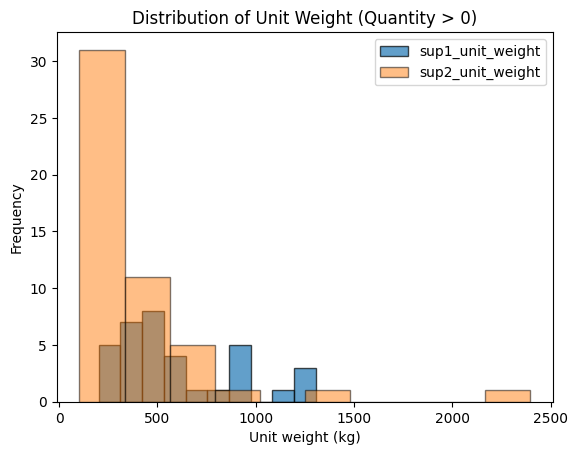

In [8]:
df1["sup1_unit_weight"].plot(kind="hist", bins=10, edgecolor="black", alpha=0.7)
df2["sup2_unit_weight"].plot(
    kind="hist", bins=10, edgecolor="black", alpha=0.5
)
plt.xlabel("Unit weight (kg)")
plt.title("Distribution of Unit Weight (Quantity > 0)")
plt.legend()
plt.show()

`sup1_unit_weight` and `sup2_unit_weight` are on the completely different scale, as well as `quantity` and `weight` like columns. Could not be used for any kind of uniqie key for join.

## Concatenate (no merge key) and save
We do not merge because there is no robust shared key across datasets.
We column-align, drop temporary helper columns, and concatenate.

In [9]:

drop_cols = [c for c in ['sup1_unit_weight','sup2_unit_weight','quantity_weight_conflict'] if c in df1.columns or c in df2.columns]
df1_export = df1.drop(columns=[c for c in drop_cols if c in df1.columns], errors='ignore')
df2_export = df2.drop(columns=[c for c in drop_cols if c in df2.columns], errors='ignore')

all_cols = sorted(set(df1_export.columns).union(set(df2_export.columns)))
df1_ext = df1_export.reindex(columns=all_cols)
df2_ext = df2_export.reindex(columns=all_cols)
inventory_df = pd.concat([df1_ext, df2_ext], ignore_index=True)

out_path = 'deliverables/inventory_dataset.csv'
inventory_df.to_csv(out_path, index=False)
inventory_df.head()

,ag,ai,article_id,coating_desc,defect_desc,finish,grade,material,quality_choice,reserved,rm,rp02,sup1_quantity,sup1_weight_kg,sup2_quantity,sup2_weight_kg,thickness_mm,width_mm
0,16.11,0.0054,NaN,NaN,Längs- oder Querisse,gebeizt und geglüht,C200S,NaN,3rd,NaN,606.2,333.6,NaN,13983.0,NaN,NaN,2.77,1100.0
1,16.11,0.0046,NaN,NaN,Längs- oder Querisse,ungebeizt,C300S,NaN,3rd,NaN,NaN,717.7,NaN,13047.0,NaN,NaN,2.65,1075.0
2,NaN,0.0061,NaN,NaN,Kantenfehler - FS-Kantenrisse,gebeizt und geglüht,C100S,NaN,3rd,NaN,NaN,368.9,10.84,14155.0,NaN,NaN,2.20,1100.0
3,NaN,0.0062,NaN,NaN,Längs- oder Querisse,gebeizt,C100S,NaN,2nd,NaN,601.7,368.9,22.87,11381.0,NaN,NaN,2.86,1100.0
4,NaN,0.0041,NaN,NaN,Sollmasse (Gewicht) unterschritten,ungebeizt,C300S,NaN,1st,NaN,1213.0,NaN,22.87,10072.0,NaN,NaN,2.88,1050.0


### Notes
- We avoided imputing any values due to weak/unstable group dependencies and small sample size.
- Implausible zeros were re-labeled as missing (NaN) for transparency.
- The resulting dataset is a straightforward union for downstream usage.